# Data Preparation and Enrichment

In [1]:
from faker import Faker
import pandas as pd
import random
import glob
import os
import numpy as np
import warnings
np.random.seed(42)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Assessing

In [2]:
datasets = {}
fileNames = []

In [3]:
for file in glob.glob('Datasets/*.csv'):
    fileName = os.path.basename(file).split('.')[0].replace('olist_', '').replace('_dataset', '')
    fileNames.append(fileName)
    datasets[fileName] = pd.read_csv(file, encoding="utf-8")

In [4]:
datasets.keys()

dict_keys(['closed_deals', 'customers', 'geolocation', 'marketing_qualified_leads', 'orders', 'order_items', 'order_payments', 'order_reviews', 'products', 'sellers', 'product_category_name_translation'])

In [5]:
datasets_info = pd.DataFrame()
datasets_info['dataset'] = fileNames
datasets_info['n_rows'] = [datasets[fileName].shape[0] for fileName in fileNames]
datasets_info['n_cols'] = [datasets[fileName].shape[1] for fileName in fileNames]
datasets_info['n_duplicates'] = [datasets[fileName].duplicated().sum() for fileName in fileNames]
datasets_info['null_counts'] = [datasets[fileName].isnull().sum().sum() for fileName in fileNames]
datasets_info['null_cols'] = [', '.join([col for col, null in datasets[fileName].isnull().sum().items() if null > 0]) for fileName in fileNames]
datasets_info.style.background_gradient()

,dataset,n_rows,n_cols,n_duplicates,null_counts,null_cols
0,closed_deals,842,14,0,3300,"business_segment, lead_type, lead_behaviour_profile, has_company, has_gtin, average_stock, business_type, declared_product_catalog_size"
1,customers,99441,5,0,0,
2,geolocation,1000163,5,261831,0,
3,marketing_qualified_leads,8000,4,0,60,origin
4,orders,99441,8,0,4908,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
5,order_items,112650,7,0,0,
6,order_payments,103886,6,0,0,
7,order_reviews,99224,7,0,145903,"review_comment_title, review_comment_message"
8,products,32951,9,0,2448,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
9,sellers,3095,4,0,0,


In [6]:
datasets_overview = pd.DataFrame(columns=['dataset_name', 'column_name', 'null_counts', 'null_proportions', 'datatypes'])
for fileName in fileNames:
    # Get null values in each column
    nulls = datasets[fileName].isnull().sum()
    nulls.name = 'null_counts'
    df_nulls = nulls.reset_index().rename(columns={'index': 'column_name'})
    df_nulls['null_proportions'] = np.round(df_nulls.null_counts.values / datasets[fileName].shape[0], decimals=4) * 100
    df_nulls['null_proportions'] = df_nulls['null_proportions'].fillna(0)
    # Get datatype for each column
    datatypes = datasets[fileName].dtypes
    datatypes.name = 'datatypes'
    df_datatypes = datatypes.reset_index().rename(columns={'index': 'column_name'})
    
    # Create a dataframe of the dataset columns info
    df = df_nulls.merge(df_datatypes, on='column_name', how='inner')
    df['dataset_name'] = fileName
    datasets_overview = pd.concat((datasets_overview, df)).reset_index(drop=True)

In [7]:
datasets_overview

,dataset_name,column_name,null_counts,null_proportions,datatypes
0,closed_deals,mql_id,0,0.00,object
1,closed_deals,seller_id,0,0.00,object
2,closed_deals,sdr_id,0,0.00,object
3,closed_deals,sr_id,0,0.00,object
4,closed_deals,won_date,0,0.00,object
5,closed_deals,business_segment,1,0.12,object
6,closed_deals,lead_type,6,0.71,object
7,closed_deals,lead_behaviour_profile,177,21.02,object
8,closed_deals,has_company,779,92.52,object
9,closed_deals,has_gtin,778,92.40,object


In [8]:
datetime_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'review_creation_date',
    'review_answer_timestamp'
]

# Convert date columns safely
for col in datetime_cols:
    if col in df.columns:
        datasets['orders'][col] = pd.to_datetime(datasets['orders'][col], errors='coerce')  # convert invalid dates to NaT
        datasets['orders'][col] = datasets['orders'][col].dt.strftime('%Y-%m-%d %H:%M:%S')  # format as consistent datetime string
        datasets['orders'][col] = datasets['orders'][col].fillna('')  # replace NaT with empty string for SSIS to interpret as NULL


## Primary Key Integrity Check
In this part, we will focus on verifying uniqueness and completeness of primary keys.
- From the above table, we can verify that all the primary key columns do not have missing values.

In [9]:
fileNames

['closed_deals',
 'customers',
 'geolocation',
 'marketing_qualified_leads',
 'orders',
 'order_items',
 'order_payments',
 'order_reviews',
 'products',
 'sellers',
 'product_category_name_translation']

In [10]:
datasets['marketing_qualified_leads'].columns

Index(['mql_id', 'first_contact_date', 'landing_page_id', 'origin'], dtype='object')

In [11]:
datasets['orders'].duplicated(subset='order_id').sum()
# Primary key (order_id)

0

- The `order_id` column is unique and not null, so it is a valid primary key.

In [12]:
datasets['order_payments'].duplicated(subset=['order_id', 'payment_sequential']).sum()
# composite primary key (order_id, payment_sequential)

0


- The `order_id` and `payment_sequential` columns are unique and not null, so they form a valid composite primary key.


In [13]:
datasets['customers'].duplicated(subset='customer_id').sum()
# Primary key (customer_id)

0

- The `customer_id` column is unique and not null, so it is a valid primary key.

In [14]:
datasets['order_items'].duplicated(subset=['order_item_id', 'order_id']).sum()
# composite primary key (order_item_id, order_id)

0

- The `order_item_id` and `order_id` columns are unique and not null, so they form a valid composite primary key.

In [15]:
datasets['products'].duplicated(subset=['product_id']).sum()
# Primary key (product_id)

0

- The `product_id` column is unique and not null, so it is a valid primary key.

In [16]:
datasets['sellers'].duplicated(subset=['seller_id']).sum()
# Primary key (seller_id)

0

- The `seller_id` column is unique and not null, so it is a valid primary key.

In [17]:
datasets['order_reviews'].duplicated(subset=['review_id', 'order_id']).sum()
# composite primary key (review_id, order_id)

0

- The `review_id` and `order_id` columns are unique and not null, so they form a valid composite primary key.

In [18]:
datasets['product_category_name_translation'].duplicated(subset=['product_category_name']).sum()
# Primary key (product_category_name)

0

- The `product_category_name` column is unique and not null, so it is a valid primary key.

In [19]:
datasets['closed_deals'].duplicated(subset=['mql_id']).sum()
# Primary key (mql_id)

0

- The `mql_id` column is unique and not null, so it is a valid primary key.

In [20]:
datasets['marketing_qualified_leads'].duplicated(subset=['mql_id']).sum()
# Primary key (mql_id)

0

- The `mql_id` column is unique and not null, so it is a valid primary key.

Let's drop the duplicate rows we found in the `gelocation` dataset

In [21]:
datasets['geolocation'] = datasets['geolocation'].drop_duplicates()

# test
datasets['geolocation'].duplicated().sum()

0

According to the data model provided by the dataset publisher, `geolocation_zip_code_prefix` is a candidate primary key. Let's verify this by checking for duplicate values in this column.

In [22]:
datasets['geolocation'].duplicated(subset=['geolocation_zip_code_prefix']).sum()

719317


- We can see that there are duplicate values in this column. Since the `geolocation`, `customers`, and `sellers` datasets share three common columns: `geolocation_zip_code_prefix`, `city`, and `state`, and our data model does not include latitude or longitude, we will drop those two columns.

- I will check the `customers` and `sellers` datasets to see if they contain any data that do not exist in the `geolocation` dataset, and append those records to the `geolocation` dataset to ensure there are no missing values when we join.

- Next, I will remove the duplicate rows from the `geolocation` dataset so that we have a unique combination of `geolocation_zip_code_prefix`, `city`, and `state`.

- After that, I will create a new primary key column named `geo_id`.

- Finally, I will join the `geolocation` dataset twice, once with the `customers` table and once with the `sellers` table, using those three columns to add the `geo_id` field. Once that is done, I will drop the `geolocation_zip_code_prefix`, `city`, and `state` columns from both the `customers` and `sellers` datasets.


In [23]:
datasets['geolocation'].columns

Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')

In [24]:
# let's drop the `geolocation_lat` and `geolocation_lng`
datasets['geolocation'].drop(['geolocation_lat', 'geolocation_lng'], axis=1, inplace=True)

# test
datasets['geolocation'].columns

Index(['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'], dtype='object')

#### Let's check if there are any rows in `customers` or `sellers` tables that do not exist in `geolocation`

In [25]:
cust_join_col = ['customer_zip_code_prefix', 'customer_city', 'customer_state']
geo_join_col = ['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state']

cust_geo_only = datasets['customers'].merge(datasets['geolocation'], left_on=cust_join_col,
                           right_on=geo_join_col, how='left', 
                                            indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])[cust_join_col]

cust_geo_only.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318 entries, 33144 to 9502769
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_zip_code_prefix  318 non-null    int64 
 1   customer_city             318 non-null    object
 2   customer_state            318 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.9+ KB


In [26]:
seller_join_col = ['seller_zip_code_prefix', 'seller_city', 'seller_state']


seller_geo_only = datasets['sellers'].merge(datasets['geolocation'], left_on=seller_join_col,
                           right_on=geo_join_col, how='left', 
                                            indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])[seller_join_col]

seller_geo_only.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, 371 to 268915
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_zip_code_prefix  137 non-null    int64 
 1   seller_city             137 non-null    object
 2   seller_state            137 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.3+ KB


- Let's enrich the `geolocation` dataset with this data so we don't have missing values when performing the joins.

In [27]:
datasets['geolocation'].columns = ['zip_code_prefix', 'city', 'state']
cust_geo_only.columns = ['zip_code_prefix', 'city', 'state']
seller_geo_only.columns = ['zip_code_prefix', 'city', 'state']

In [28]:
datasets['geolocation'] = pd.concat((datasets['geolocation'], cust_geo_only, seller_geo_only))

In [29]:
# check duplicate rows
datasets['geolocation'].duplicated().sum()

710566

In [30]:
# drop duplicate rows
datasets['geolocation'].drop_duplicates(inplace=True)

# test
datasets['geolocation'].duplicated().sum()

0

In [31]:
datasets['geolocation'].shape

(28221, 3)

In [32]:
# create a new primary key column `geo_id`
datasets['geolocation']['geo_id'] = list(range(0, datasets['geolocation'].shape[0]))

In [33]:
datasets['geolocation'].head()

,zip_code_prefix,city,state,geo_id
0,1037,sao paulo,SP,0
1,1046,sao paulo,SP,1
3,1041,sao paulo,SP,2
4,1035,sao paulo,SP,3
5,1012,são paulo,SP,4


In [34]:
datasets['geolocation'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 28221 entries, 0 to 268915
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   zip_code_prefix  28221 non-null  int64 
 1   city             28221 non-null  object
 2   state            28221 non-null  object
 3   geo_id           28221 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.1+ MB


#### Add `geo_id` to `customers` table

In [35]:
datasets['customers'].shape

(99441, 5)

In [36]:
# add `geo_id` to `customers` table

geo_join_col = ['zip_code_prefix', 'city', 'state']

datasets['customers'] = datasets['customers'].merge(datasets['geolocation'], left_on=cust_join_col,
                           right_on=geo_join_col, how='left')

datasets['customers'] = datasets['customers'][['customer_id', 'customer_unique_id', 'geo_id']]
datasets['customers'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         99441 non-null  object
 1   customer_unique_id  99441 non-null  object
 2   geo_id              99441 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


### Add `geo_id` to `sellers` table

In [37]:
datasets['sellers'].shape

(3095, 4)

In [38]:
datasets['sellers'] = datasets['sellers'].merge(datasets['geolocation'], left_on=seller_join_col,
                           right_on=geo_join_col, how='left')

datasets['sellers'] = datasets['sellers'][['seller_id', 'geo_id']]
datasets['sellers'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   seller_id  3095 non-null   object
 1   geo_id     3095 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 48.5+ KB


#### Join `products` and `product_category_name_translation`

In [39]:
datasets['products'] = datasets['products'].merge(datasets['product_category_name_translation'], on='product_category_name', how='left')

In [40]:
datasets['products'].drop('product_category_name', axis=1, inplace=True)

In [41]:
datasets['products'] = datasets['products'].rename(columns={'product_category_name_english': 'product_category_name'})

## Check Cardinality

#### Check whether the relationship between `reviews` and `orders` is one-to-one, as indicated in the data model.
- Then, we will merge the two tables to align with our data model.

In [42]:
datasets['order_reviews'].order_id.value_counts()

order_id
c88b1d1b157a9999ce368f218a407141    3
8e17072ec97ce29f0e1f111e598b0c85    3
df56136b8031ecd28e200bb18e6ddb2e    3
03c939fd7fd3b38f8485a0f95798f1f6    3
5cb890a68b91b6158d69257e4e2bc359    2
                                   ..
5b4e9a12d219f34f5c2de9f8d620b19d    1
a6da096d974acc000962856d7386448a    1
75e0647c26de647eca3421e9cc66c9da    1
bad0467c52f23cdc71e9fa139d4a8afd    1
90531360ecb1eec2a1fbb265a0db0508    1
Name: count, Length: 98673, dtype: int64

- There are some orders that have received more than one review. Let's investigate this further.

In [43]:
datasets['order_reviews'][datasets['order_reviews'].order_id == '8e17072ec97ce29f0e1f111e598b0c85']

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
44694,67c2557eb0bd72e3ece1e03477c9dff5,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,Entregou o produto errado.,2018-04-07 00:00:00,2018-04-08 22:48:27
64510,2d6ac45f859465b5c185274a1c929637,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,Comprei 3 unidades do produto vieram 2 unidade...,2018-04-07 00:00:00,2018-04-07 21:13:05
92300,6e4c4086d9611ae4cc0cc65a262751fe,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,"Embora tenha entregue dentro do prazo, não env...",2018-04-14 00:00:00,2018-04-16 11:37:31


- The customer can submit multiple reviews for the same order after it has been received. To align with our data model design, I will keep only the review with the most recent `review_answer_timestamp`.


In [44]:
# Change the data type to datetime
datasets['order_reviews'].review_answer_timestamp = pd.to_datetime(datasets['order_reviews'].review_answer_timestamp)

In [45]:
# rank the reviews per order by review_answer_timestamp
datasets['order_reviews']['row_number'] = datasets['order_reviews'].groupby('order_id')['review_answer_timestamp'].rank(method='first', 
                                                                                                                        ascending=False)


In [46]:
# Check that the ranking is working correctly and it assigns one to the most recent date.
datasets['order_reviews'][datasets['order_reviews'].order_id == '8e17072ec97ce29f0e1f111e598b0c85']

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,row_number
44694,67c2557eb0bd72e3ece1e03477c9dff5,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,Entregou o produto errado.,2018-04-07 00:00:00,2018-04-08 22:48:27,2.0
64510,2d6ac45f859465b5c185274a1c929637,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,Comprei 3 unidades do produto vieram 2 unidade...,2018-04-07 00:00:00,2018-04-07 21:13:05,3.0
92300,6e4c4086d9611ae4cc0cc65a262751fe,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,"Embora tenha entregue dentro do prazo, não env...",2018-04-14 00:00:00,2018-04-16 11:37:31,1.0


In [47]:
datasets['order_reviews'] = datasets['order_reviews'][datasets['order_reviews'].row_number == 1.0].drop('row_number', axis=1)

In [48]:
# Test whether the code worked and confirm that only the most recent review was kept.
datasets['order_reviews'][datasets['order_reviews'].order_id == '8e17072ec97ce29f0e1f111e598b0c85']
# Done :)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
92300,6e4c4086d9611ae4cc0cc65a262751fe,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,"Embora tenha entregue dentro do prazo, não env...",2018-04-14 00:00:00,2018-04-16 11:37:31


In [49]:
datasets['order_reviews'].order_id.value_counts()
# yes, it is one to one

order_id
73fc7af87114b39712e6da79b0a377eb    1
2ae6bf810adb8aa11c97527eb4e62a15    1
6051e6d3da9a50b7325cbe9c81025062    1
2e2d43380f2a8c56a9378e75b9b474fe    1
b2c1d65b858a8658622354076fafbd0c    1
                                   ..
659a4b8e5c9540667f4d4d5607bc8f79    1
d92888ccf9b2ae4399868e099fadf925    1
ea5eae45d22308768d97e85db1d51269    1
260799d8b7f9539cd4cd5a5e513a281d    1
90531360ecb1eec2a1fbb265a0db0508    1
Name: count, Length: 98673, dtype: int64

In [50]:
datasets['orders'].shape

(99441, 8)

In [51]:
datasets['orders'] = datasets['orders'].merge(datasets['order_reviews'], on='order_id', how='left')

In [52]:
datasets['orders'] = datasets['orders'].drop('review_id', axis=1)

datasets['orders'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  object        
 4   order_approved_at              99281 non-null  object        
 5   order_delivered_carrier_date   97658 non-null  object        
 6   order_delivered_customer_date  96476 non-null  object        
 7   order_estimated_delivery_date  99441 non-null  object        
 8   review_score                   98673 non-null  float64       
 9   review_comment_title           11550 non-null  object        
 10  review_comment_message         40775 non-null  object        
 11  review_creation

### Check whether the relationship between customers and orders is one-to-many, as indicated in the data model.

In [53]:
datasets['orders'].customer_id.value_counts()

customer_id
9ef432eb6251297304e76186b10a928d    1
413f7e58270a32396af030a075b924be    1
eb4350b67a0264c67e5e06a038e4afbb    1
622b07d262d545d16efbd4363a89cb91    1
c701fbfa77791abd05eef9eacf7ea7a8    1
                                   ..
39585f08d13377e50fde35467984e6eb    1
eb3d995301c320683de629f5b4dd0c78    1
f2507ea56d748a23037bb1214964e87d    1
ae8269d850cd3a3d06a56877c450b3f8    1
edb027a75a1449115f6b43211ae02a24    1
Name: count, Length: 99441, dtype: int64

- Yes, that makes sense. The issue occurs because `customer_id` is not unique for each customer.
- We'll fix it by joining the two tables on the `customer_id` column to bring `customer_unique_id` into the `orders` table. Then, we’ll drop `customer_id` from both tables and remove duplicates from the `customers` table to ensure each customer is represented once.


In [54]:
datasets['orders'] = datasets['orders'].merge(datasets['customers'][['customer_id', 'customer_unique_id']], on='customer_id', how='left')
datasets['orders'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  object        
 4   order_approved_at              99281 non-null  object        
 5   order_delivered_carrier_date   97658 non-null  object        
 6   order_delivered_customer_date  96476 non-null  object        
 7   order_estimated_delivery_date  99441 non-null  object        
 8   review_score                   98673 non-null  float64       
 9   review_comment_title           11550 non-null  object        
 10  review_comment_message         40775 non-null  object        
 11  review_creation

In [55]:
datasets['customers'].drop('customer_id', axis=1, inplace=True)
datasets['orders'].drop('customer_id', axis=1, inplace=True)

In [56]:
print(('customer_id' in datasets['customers'].columns) | ('customer_id' in datasets['orders'].columns))

False


In [57]:
datasets['customers'].duplicated().sum()

3089

In [58]:
datasets['customers'].drop_duplicates(subset='customer_unique_id', inplace=True)

In [59]:
datasets['customers'].duplicated().sum()

0

In [60]:
datasets['customers'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 96096 entries, 0 to 99440
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_unique_id  96096 non-null  object
 1   geo_id              96096 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ MB


#### Check whether the relationship between `sellers` and `closed_deals` is one-to-one, as indicated in the data model.


In [61]:
datasets['closed_deals'].seller_id.value_counts()

seller_id
2c43fb513632d29b3b58df74816f1b06    1
c092292535a57dacd95a8765f5518f87    1
de83e0600df76319c24c3670ebcb2d5f    1
85182120f8a3331fcddb54f27a77dda2    1
bb219facd42c2384181e8f3330b42df9    1
                                   ..
76bf0e3e7d311d9069d4512cc1a232d7    1
4ff8d644ff76721b86fdc7c75c48d4a6    1
59ddca14932ec5557c099a51c4d5a58e    1
8c9348f33ae3dada25c99c99ade2af78    1
1bba9c94eb5c4e82fba9f7286fe81025    1
Name: count, Length: 842, dtype: int64

## Data Generation and Enrichment

* Handle Missing Seller Records in the `closed_deals`:
    * Address the data integrity issue where some sellers exist in the `closed_deals` table but not in the main `sellers` table.
    * Impute these missing seller records using data from valid sellers found in the `sellers` table.
* Impute `declared_product_catalog_size`:
    * Fill in missing values for each seller with their actual count of unique products sold.

* Impute `declared_monthly_revenue`:
    * Fill in missing values for each seller with their total revenue, calculated as the sum of `price` and `freight_value` for all items they have sold.
    
* Generate data for `customer_name` and `customer_gender` in the `customers` table, and for `seller_name` and `seller_gender` in the `sellers` table.
* Create a new `employees` table based on the sales representatives and sales development representatives' IDs from the data, and generate names for those employees. Then, add the Facebook page URL for some of the sales reps.
  




In [62]:
datasets.keys()

dict_keys(['closed_deals', 'customers', 'geolocation', 'marketing_qualified_leads', 'orders', 'order_items', 'order_payments', 'order_reviews', 'products', 'sellers', 'product_category_name_translation'])

In [63]:
closed_deals_clean = datasets['closed_deals'].copy()

In [64]:
summary_seller = datasets['order_items'].groupby('seller_id', as_index=False).agg(
    # Creates a new column 'unique_products' by counting the unique product_id's for each seller
    unique_products=('product_id', 'nunique'),
    
    # Creates a new column 'total_revenue' by summing the price for each seller
    total_revenue=('price', 'sum')
)
summary_seller

,seller_id,unique_products,total_revenue
0,0015a82c2db000af6aaaf3ae2ecb0532,1,2685.00
1,001cca7ae9ae17fb1caed9dfb1094831,11,25080.03
2,001e6ad469a905060d959994f1b41e4f,1,250.00
3,002100f778ceb8431b7a1020ff7ab48f,24,1234.50
4,003554e2dce176b5555353e4f3555ac8,1,120.00
...,...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,1,69.90
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,12,2101.20
3092,ffeee66ac5d5a62fe688b9d26f83f534,3,1839.86
3093,fffd5413c0700ac820c7069d66d98c89,29,9062.30


In [65]:
# Get sets of seller IDs from each dataset
sellers_in_master = set(datasets['sellers']['seller_id'])
sellers_in_closed_deals = set(closed_deals_clean['seller_id'])

# Identify sellers that exist in sellers table but have no closed deals
sellers_without_deals = sellers_in_master - sellers_in_closed_deals
# Identify orphan seller IDs (appear in closed_deals but not in sellers table)
orphan_seller_ids = sellers_in_closed_deals - sellers_in_master

summary_seller_without_deals = summary_seller[summary_seller.seller_id.isin(sellers_without_deals)]
summary_seller_with_deals = summary_seller[summary_seller.seller_id.isin(sellers_in_master & sellers_in_closed_deals)]

mask1 = (summary_seller_without_deals.unique_products > summary_seller_without_deals.unique_products.median()) 
mask2 = (summary_seller_without_deals.total_revenue > summary_seller_without_deals.total_revenue.median())
summary_seller_without_deals = summary_seller_without_deals[mask1 & mask2]


# Randomly assign valid seller IDs from sellers_without_deals to replace orphan ones
replacement_seller_ids = np.random.choice(
    list(summary_seller_without_deals.seller_id), 
    size=len(orphan_seller_ids), 
    replace=False
)

# Replace orphan seller IDs in closed_deals with valid replacements
closed_deals_clean.loc[
    closed_deals_clean['seller_id'].isin(orphan_seller_ids), 
    'seller_id'
] = replacement_seller_ids

# Check results
print("Unique sellers after replacement:", closed_deals_clean['seller_id'].nunique())
print("All sellers valid:", closed_deals_clean['seller_id'].isin(sellers_in_master).all())


Unique sellers after replacement: 842
All sellers valid: True


In [66]:
added_sellers = summary_seller_without_deals[summary_seller_without_deals.seller_id.isin(replacement_seller_ids)]

summary_seller_with_deals = pd.concat((summary_seller_with_deals, added_sellers), axis=0)
summary_seller_with_deals.shape

(842, 3)

In [67]:
closed_deals_clean = closed_deals_clean.merge(summary_seller_with_deals, on='seller_id', how='inner')

closed_deals_clean['total_revenue'] = closed_deals_clean['total_revenue'] * np.random.uniform(0.85, 1.15, len(closed_deals_clean))

# Optionally round to 2 decimals for realism
closed_deals_clean['total_revenue'] = closed_deals_clean['total_revenue'].round(2)

closed_deals_clean['declared_product_catalog_size'] = np.where(
    (closed_deals_clean['declared_product_catalog_size'].isna()) | (closed_deals_clean['declared_product_catalog_size'] == 0),
    closed_deals_clean['unique_products'],  # Use the value from summary
    closed_deals_clean['declared_product_catalog_size']  # Keep the original
)

closed_deals_clean['declared_monthly_revenue'] = np.where(
    (closed_deals_clean['declared_monthly_revenue'].isna()) | (closed_deals_clean['declared_monthly_revenue'] == 0),
    closed_deals_clean['total_revenue'],  # Use the value from summary
    closed_deals_clean['declared_monthly_revenue']  # Keep the original
)

In [68]:
closed_deals_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842 entries, 0 to 841
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   mql_id                         842 non-null    object 
 1   seller_id                      842 non-null    object 
 2   sdr_id                         842 non-null    object 
 3   sr_id                          842 non-null    object 
 4   won_date                       842 non-null    object 
 5   business_segment               841 non-null    object 
 6   lead_type                      836 non-null    object 
 7   lead_behaviour_profile         665 non-null    object 
 8   has_company                    63 non-null     object 
 9   has_gtin                       64 non-null     object 
 10  average_stock                  66 non-null     object 
 11  business_type                  832 non-null    object 
 12  declared_product_catalog_size  842 non-null    flo

In [69]:
closed_deals_clean = closed_deals_clean.drop(['unique_products', 'total_revenue'], axis=1)

datasets['closed_deals'] = closed_deals_clean

### Create Employee Table

In [70]:
sr_ids = datasets['closed_deals'].sr_id.unique().tolist()
sdr_ids = datasets['closed_deals'].sdr_id.unique().tolist()

In [71]:
len(sr_ids), len(sdr_ids)

(22, 32)

In [72]:
set([1, 2, 3]) - set([2, 4, 5])

{1, 3}

In [73]:
sr_and_sdr_ids = set(sr_ids) & set(sdr_ids)
sr_ids = set(sr_ids) - sr_and_sdr_ids
sdr_ids = set(sdr_ids) - sr_and_sdr_ids

def get_role_type(emp_id):
    if emp_id in sr_and_sdr_ids:
        return 'Both'
    elif emp_id in sr_ids:
        return 'Sales Representative'
    elif emp_id in sdr_ids:
        return 'Sales Development Representative'

In [74]:
len(sr_and_sdr_ids)

13

In [75]:
emps_ids = list(sr_and_sdr_ids) + list(sr_ids) + list(sdr_ids)
emps_roles = [get_role_type(emp_id) for emp_id in emps_ids]

- There are employees who have worked as both Sales Representatives (SR) and Sales Development Representatives (SDR).


In [76]:
print('Number of Employees: ', len(emps_ids))

Number of Employees:  41


In [77]:
def generate_names(n=10000, locale='en_US', seed=42):
    fake = Faker(locale)
    Faker.seed(seed)
    random.seed(seed)

    names_set = set()
    rows = []
    i = 0

    # keep generating until we have n unique full names
    while len(names_set) < n:
        gender = random.choice(['Male', 'Female'])

        if gender == 'Male':
            first = fake.first_name_male()
        else:
            first = fake.first_name_female()
        
        last = fake.last_name()
        full = f"{first} {last}"

        # ensure uniqueness
        if full in names_set:
            continue

        names_set.add(full)
        i += 1

        rows.append({
            'first_name': first,
            'last_name': last,
            'full_name': full,
            'gender': gender
        })

        # Optional: periodically print progress for very large n
        # if i % 10000 == 0:
        #     print(f"{i} unique names generated...")

    df = pd.DataFrame(rows)
    return df

In [78]:
df_emps = generate_names(41, locale='en_US', seed=123)
df_emps['employee_id'] = emps_ids
df_emps['role'] = emps_roles
print(df_emps.full_name.duplicated().sum())

0


In [79]:
df_emps.drop('full_name', axis=1, inplace=True)
df_emps.head()

,first_name,last_name,gender,employee_id,role
0,Anthony,Miller,Male,56bf83c4bb35763a51c2baab501b4c67,Both
1,Jennifer,Rodriguez,Female,068066e24f0c643eb1d089c7dd20cd73,Both
2,Steven,Johnson,Male,6aa3b86a83d784b05f0e37e26b20860d,Both
3,Kimberly,Cook,Female,34d40cdaf94010a1d05b0d6212f9e909,Both
4,Sarah,Moore,Female,9d12ef1a7eca3ec58c545c678af7869c,Both


In [80]:
facebook_urls = ['NourGhanaym',
                'toota.mohamed.3998', 
                 'abdelwahed.demo.5', 
                'basma.hesham.14661',
                 'reaalsalah']
user_names = ["Nour Ghanaym", "Sondos Mohamed", "Adblwahed Nasr", "Basma Hesham", "Reaal Salah"]

df_emps['facebook_user_id'] = facebook_urls + [np.nan] * (df_emps.shape[0] - 5)

df_emps.first_name = [name.split()[0] for name in user_names] + list(df_emps.first_name)[5:]
df_emps.last_name = [name.split()[1] for name in user_names] + list(df_emps.last_name)[5:]
df_emps.head()

,first_name,last_name,gender,employee_id,role,facebook_user_id
0,Nour,Ghanaym,Male,56bf83c4bb35763a51c2baab501b4c67,Both,NourGhanaym
1,Sondos,Mohamed,Female,068066e24f0c643eb1d089c7dd20cd73,Both,toota.mohamed.3998
2,Adblwahed,Nasr,Male,6aa3b86a83d784b05f0e37e26b20860d,Both,abdelwahed.demo.5
3,Basma,Hesham,Female,34d40cdaf94010a1d05b0d6212f9e909,Both,basma.hesham.14661
4,Reaal,Salah,Female,9d12ef1a7eca3ec58c545c678af7869c,Both,reaalsalah


In [81]:
df_emps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   first_name        41 non-null     object
 1   last_name         41 non-null     object
 2   gender            41 non-null     object
 3   employee_id       41 non-null     object
 4   role              41 non-null     object
 5   facebook_user_id  5 non-null      object
dtypes: object(6)
memory usage: 2.1+ KB


### Generate Seller Name and Gender

In [82]:
df_seller_generated = generate_names(datasets['sellers'].shape[0], locale='en_US', seed=123)

In [83]:
df_seller_generated.shape

(3095, 4)

In [84]:
df_seller_generated.full_name.duplicated().sum()

0

In [85]:
datasets['sellers']['first_name'] = df_seller_generated['first_name']
datasets['sellers']['last_name'] = df_seller_generated['last_name']
datasets['sellers']['gender'] = df_seller_generated['gender']

datasets['sellers'].head()

,seller_id,geo_id,first_name,last_name,gender
0,3442f8959a84dea7ee197c632cb2df15,8494,Anthony,Miller,Male
1,d1b65fc7debc3361ea86b5f14c68d2e2,9021,Jennifer,Rodriguez,Female
2,ce3ad9de960102d0677a81f5d0bb7b2d,10681,Steven,Johnson,Male
3,c0f3eea2e14555b6faeea3dd58c1b1c3,3419,Kimberly,Cook,Female
4,51a04a8a6bdcb23deccc82b0b80742cf,8456,Sarah,Moore,Female


### Generate Customer Name and Gender

In [86]:
df_customer_generated = generate_names(datasets['customers'].shape[0], locale='en_US', seed=123)
df_customer_generated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   first_name  96096 non-null  object
 1   last_name   96096 non-null  object
 2   full_name   96096 non-null  object
 3   gender      96096 non-null  object
dtypes: object(4)
memory usage: 2.9+ MB


In [87]:
datasets['customers'].shape[0]

96096

In [88]:
df_customer_generated.full_name.duplicated().sum()

0

In [89]:
datasets['customers'].reset_index(inplace=True)

In [90]:
datasets['customers']['first_name'] = df_customer_generated['first_name']
datasets['customers']['last_name'] = df_customer_generated['last_name']
datasets['customers']['gender'] = df_customer_generated['gender']

datasets['customers'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   index               96096 non-null  int64 
 1   customer_unique_id  96096 non-null  object
 2   geo_id              96096 non-null  int64 
 3   first_name          96096 non-null  object
 4   last_name           96096 non-null  object
 5   gender              96096 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.4+ MB


#### Add Generated Customers Age

In [91]:
customers_with_age = pd.read_excel('Datasets_Modified/customers_with_age.xlsx')
customers_with_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_unique_id  96096 non-null  object
 1   Age                 96096 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


<Axes: >

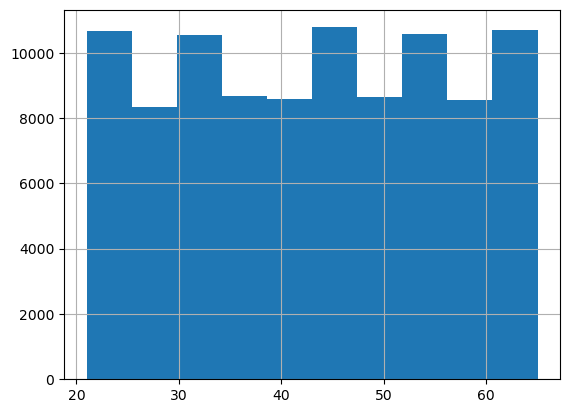

In [92]:
customers_with_age.Age.hist()

In [93]:
datasets['customers'] = datasets['customers'].merge(customers_with_age, on='customer_unique_id', how='left')

#### Add Generated Products Names

In [94]:
products_with_names = pd.read_excel('Datasets_Modified/products_with_name.xlsx')
products_with_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Brand          32951 non-null  object
 1   Category Name  32951 non-null  object
 2   Product Name   32951 non-null  object
dtypes: object(3)
memory usage: 772.4+ KB


In [95]:
datasets['products'].product_id.nunique()

32951

In [96]:
products_with_names[products_with_names['Category Name'] == 'other'].shape

(623, 3)

In [97]:
datasets['products'].product_category_name.isnull().sum()

623

In [98]:
datasets['products'].product_category_name.fillna('other', inplace=True)

(datasets['products'].product_category_name == 'other').sum()

623

In [99]:
df_prd_group = products_with_names.groupby('Category Name', as_index=False)['Product Name'].nunique().sort_values(by='Category Name')

n_products_per_cat = datasets['products'].groupby('product_category_name', as_index=False)['product_id'].nunique().sort_values(by='product_category_name')

In [100]:
prd_cat_gen = df_prd_group.merge(n_products_per_cat, left_on='Category Name', right_on='product_category_name', suffixes=('gen', 'real'),
         how='inner')
prd_cat_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Category Name          72 non-null     object
 1   Product Name           72 non-null     int64 
 2   product_category_name  72 non-null     object
 3   product_id             72 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 2.4+ KB


In [101]:
prd_cat_gen

,Category Name,Product Name,product_category_name,product_id
0,agro_industry_and_commerce,74,agro_industry_and_commerce,74
1,air_conditioning,124,air_conditioning,124
2,art,55,art,55
3,arts_and_craftmanship,19,arts_and_craftmanship,19
4,audio,58,audio,58
5,auto,1900,auto,1900
6,baby,919,baby,919
7,bed_bath_table,3029,bed_bath_table,3029
8,books_general_interest,216,books_general_interest,216
9,books_imported,31,books_imported,31


In [102]:
prd_cat_gen['diff'] =  prd_cat_gen['product_id'] - prd_cat_gen['Product Name']

In [103]:
prd_cat_gen['diff'].sum()

0

In [104]:
(prd_cat_gen['Category Name'] == prd_cat_gen['product_category_name']).all()

True

In [105]:
datasets['products']['product_name'] = np.nan
datasets['products']['brand'] = np.nan

for cat in datasets['products']['product_category_name'].unique():
    prd_names = products_with_names.loc[
        products_with_names['Category Name'] == cat, 'Product Name'
    ].tolist()
    brands = products_with_names.loc[
        products_with_names['Category Name'] == cat, 'Brand'
    ].tolist()

    mask = datasets['products']['product_category_name'] == cat
    n_rows = mask.sum()

    # Only assign if lengths match exactly
    if len(prd_names) == n_rows:
        datasets['products'].loc[mask, 'product_name'] = prd_names
        datasets['products'].loc[mask, 'brand'] = brands
    else:
        print(f"Skipping {cat}: {len(prd_names)} names vs {n_rows} products")


In [106]:
datasets['products'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_name_lenght         32341 non-null  float64
 2   product_description_lenght  32341 non-null  float64
 3   product_photos_qty          32341 non-null  float64
 4   product_weight_g            32949 non-null  float64
 5   product_length_cm           32949 non-null  float64
 6   product_height_cm           32949 non-null  float64
 7   product_width_cm            32949 non-null  float64
 8   product_category_name       32951 non-null  object 
 9   product_name                32951 non-null  object 
 10  brand                       32951 non-null  object 
dtypes: float64(7), object(4)
memory usage: 2.8+ MB


In [107]:
test_res = datasets['products'].groupby('product_category_name')[['product_id', 'product_name']].nunique()
(test_res.product_id == test_res.product_name).all()

True

## Save Modified Datasets

In [108]:
datasets['products'].columns

Index(['product_id', 'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'product_category_name',
       'product_name', 'brand'],
      dtype='object')

In [109]:
datasets['customers'] = datasets['customers'][['customer_unique_id', 'first_name', 'last_name', 'gender', 'Age', 'geo_id']]

In [110]:
datasets['sellers'] = datasets['sellers'][['seller_id', 'first_name', 'last_name', 'gender', 'geo_id']]

In [111]:
datasets['geolocation'] = datasets['geolocation'][['geo_id', 'zip_code_prefix', 'city', 'state']]

In [112]:
datasets['products'] = datasets['products'][['product_id', 'product_name', 'brand', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm']]

In [113]:
df_emps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   first_name        41 non-null     object
 1   last_name         41 non-null     object
 2   gender            41 non-null     object
 3   employee_id       41 non-null     object
 4   role              41 non-null     object
 5   facebook_user_id  5 non-null      object
dtypes: object(6)
memory usage: 2.1+ KB


In [114]:
df_emps = df_emps[['employee_id', 'first_name', 'last_name', 'gender', 'role', 'facebook_user_id']]

In [115]:
for fileName in datasets.keys():
    datasets[fileName].to_excel(f'Datasets_Modified/{fileName}.xlsx', index=False)



In [116]:
df_emps.to_excel('Datasets_Modified/sales_reps.xlsx', index=False)

## Compare with SSIS Output

In [117]:
for file_name in datasets.keys():
    print(f'{file_name}: ', datasets[file_name].shape)
df_emps.shape

closed_deals:  (842, 14)
customers:  (96096, 6)
geolocation:  (28221, 4)
marketing_qualified_leads:  (8000, 4)
orders:  (99441, 13)
order_items:  (112650, 7)
order_payments:  (103886, 6)
order_reviews:  (98673, 7)
products:  (32951, 11)
sellers:  (3095, 5)
product_category_name_translation:  (71, 2)


(41, 6)